<a href="https://colab.research.google.com/github/greyhound101/Multihead_attention/blob/master/multihead_no_flatten_4_2416.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive
Mounted at /content/gdrive


In [2]:
import zipfile
import h5py
from tensorflow.keras.optimizers import *
import cv2
from tensorflow.keras.utils import to_categorical
import glob, os
from matplotlib import pyplot as plt
import h5py
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm
import time
import gc
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model

In [3]:
path = F"/content/gdrive/My Drive/check.npy" 
df=np.load(path,allow_pickle=True)
df=df.item()

In [4]:

#shuffle samples
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]



#change targets
def change(img):
    resized = cv2.resize(img, (224,224), interpolation = cv2.INTER_AREA )
    return resized




#get train and test splits
def get_trn_tst(df,tst_fold):
  idx=np.asarray(df['fold'])
  y=np.asarray(df['label'])
  y-=1
  img=np.asarray(df['image'])
  img1=[]
  for i in range(len(img)):
        img1.append(change(img[i]))
  img1=np.asarray(img1)
  del([img])
  gc.collect()
  trn_y=np.asarray(y[(idx!=tst_fold)])
  trn_img=np.asarray(img1[(idx!=tst_fold)])
  tst_y=np.asarray(y[(idx==tst_fold)])
  tst_img=img1[idx==tst_fold]
  trn_img=np.repeat(trn_img.reshape((trn_img.shape[0],224,224,1)),3,axis=3)
  tst_img=np.repeat(tst_img.reshape((tst_img.shape[0],224,224,1)),3,axis=3)
  return (trn_img.copy(),trn_y.copy()),(tst_img.copy(),tst_y.copy())

In [5]:
from tensorflow.keras.layers import *
import tensorflow as tf
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf

In [6]:
from tensorflow import keras
from tensorflow.keras import backend as K
class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape
class abc(keras.layers.Layer):
    def __init__(self,
                 head_num,
                 q_k,
                 activation='relu',
                 use_bias=True,
                 kernel_initializer='glorot_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 history_only=False,
                 **kwargs):
        self.q_k=q_k
        self.supports_masking = True
        self.head_num = head_num
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)
        self.kernel_constraint = keras.constraints.get(kernel_constraint)
        self.bias_constraint = keras.constraints.get(bias_constraint)
        self.history_only = history_only

        self.Wq = self.Wk = self.Wv = self.Wo = None
        self.bq = self.bk = self.bv = self.bo = None

        self.intensity = self.attention = None
        super(abc, self).__init__(**kwargs)

    def get_config(self):
        config = {
            'head_num': self.head_num,
            'activation': keras.activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': keras.initializers.serialize(self.kernel_initializer),
            'bias_initializer': keras.initializers.serialize(self.bias_initializer),
            'kernel_regularizer': keras.regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': keras.regularizers.serialize(self.bias_regularizer),
            'kernel_constraint': keras.constraints.serialize(self.kernel_constraint),
            'bias_constraint': keras.constraints.serialize(self.bias_constraint),
            'history_only': self.history_only,
        }
        base_config = super(abc, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            q, k, v = input_shape
            return q[:-1] + (v[-1],)
        return input_shape

    def compute_mask(self, inputs, input_mask=None):
        if isinstance(input_mask, list):
            return input_mask[0]
        return input_mask

    def build(self, input_shape):
        self.layer_norm = LayerNormalization()
        if isinstance(input_shape, list):
            q, k, v = input_shape
        else:
            q = k = v = input_shape
        feature_dim = int(v[-1])
        if feature_dim % self.head_num != 0:
            raise IndexError('Invalid head number %d with the given input dim %d' % (self.head_num, feature_dim))
        self.Wq = self.add_weight(
            shape=(int(q[-1]), self.q_k),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wq' % self.name,
        )
        if self.use_bias:
            self.bq = self.add_weight(
                shape=(self.q_k,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bq' % self.name,
            )
        self.Wk = self.add_weight(
            shape=(int(k[-1]), self.q_k),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wk' % self.name,
        )
        if self.use_bias:
            self.bk = self.add_weight(
                shape=(self.q_k,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bk' % self.name,
            )
        self.Wv = self.add_weight(
            shape=(int(v[-1]), feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wv' % self.name,
        )
        if self.use_bias:
            self.bv = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bv' % self.name,
            )
        self.Wo = self.add_weight(
            shape=(feature_dim, feature_dim),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            name='%s_Wo' % self.name,
        )
        if self.use_bias:
            self.bo = self.add_weight(
                shape=(feature_dim,),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                name='%s_bo' % self.name,
            )
        super(abc, self).build(input_shape)

    @staticmethod
    def _reshape_to_batches(x, head_num):
        input_shape = K.shape(x)
        batch_size, seq_len, feature_dim = input_shape[0], input_shape[1], input_shape[2]
        head_dim = feature_dim // head_num
        x = K.reshape(x, (batch_size, seq_len, head_num, head_dim))
        x = K.permute_dimensions(x, [0, 2, 1, 3])
        return K.reshape(x, (batch_size * head_num, seq_len, head_dim))

    @staticmethod
    def _reshape_attention_from_batches(x, head_num):
        input_shape = K.shape(x)
        batch_size, seq_len, feature_dim = input_shape[0], input_shape[1], input_shape[2]
        x = K.reshape(x, (batch_size // head_num, head_num, seq_len, feature_dim))
        return K.permute_dimensions(x, [0, 2, 1, 3])

    @staticmethod
    def _reshape_from_batches(x, head_num):
        input_shape = K.shape(x)
        batch_size, seq_len, feature_dim = input_shape[0], input_shape[1], input_shape[2]
        x = K.reshape(x, (batch_size // head_num, head_num, seq_len, feature_dim))
        x = K.permute_dimensions(x, [0, 2, 1, 3])
        return K.reshape(x, (batch_size // head_num, seq_len, feature_dim * head_num))

    @staticmethod
    def _reshape_mask(mask, head_num):
        if mask is None:
            return mask
        seq_len = K.shape(mask)[1]
        mask = K.expand_dims(mask, axis=1)
        mask = K.tile(mask, [1, head_num, 1])
        return K.reshape(mask, (-1, seq_len))

    def call(self, inputs, mask=None):
        if isinstance(inputs, list):
            q, k, v = inputs
        else:
            q = k = v = inputs
        if isinstance(mask, list):
            q_mask, k_mask, v_mask = mask
        else:
            q_mask = k_mask = v_mask = mask
        q = K.dot(q, self.Wq)
        k = K.dot(k, self.Wk)
        v = K.dot(v, self.Wv)
        if self.use_bias:
            q += self.bq
            k += self.bk
            v += self.bv
        if self.activation is not None:
            q = self.activation(q)
            k = self.activation(k)
            v = self.activation(v)
        def scaled_dot_product_attention(inputs):
          query, key, value = inputs
          feature_dim = K.shape(query)[-1]
          e = K.batch_dot(query, key, axes=2) / K.sqrt(K.cast(self.q_k, dtype=K.floatx()))
          intensity = e
          e = K.exp(e - K.max(e, axis=-1, keepdims=True))
          attention = e / K.sum(e, axis=-1, keepdims=True)
          v = K.batch_dot(attention, value)
          return v,intensity,attention
       
       
        y,intensity,attention = scaled_dot_product_attention(
            inputs=[
                self._reshape_to_batches(q, self.head_num),
                self._reshape_to_batches(k, self.head_num),
                self._reshape_to_batches(v, self.head_num),
            ]
        )
        self.intensity = self._reshape_attention_from_batches(intensity, self.head_num)
        self.attention = self._reshape_attention_from_batches(attention, self.head_num)
        y = self._reshape_from_batches(y, self.head_num)
        y = K.dot(y, self.Wo)
        if self.use_bias:
            y += self.bo
        if self.activation is not None:
            y = self.activation(y)
        return y

In [7]:
from tensorflow import keras 
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import *
from tensorflow.keras.applications import *
def load_model():   
  
  K.clear_session() 
  mod=densenet.DenseNet121(include_top=True, weights='imagenet')
  d = mod.get_layer('conv5_block16_concat').output

  inp = mod.get_layer('conv3_block12_concat').output
  a = Reshape((28*28,512))(inp)
  d_a = Conv2D(512,1, name='here_1_1')(d)
  d_a = keras.layers.UpSampling2D(interpolation='bilinear',size=(4,4))(d_a)
  d_a = Reshape((28*28,512))(d_a)
  a = abc(head_num=8,q_k=4096)([a,d_a,a])
  a = LayerNormalization()(a)
  a = Reshape((28,28,512,))(a)
  a = keras.layers.GlobalAveragePooling2D()(a)

  inp = mod.get_layer('conv4_block24_concat').output
  b = Reshape((14*14,1024))(inp)
  d_b = Conv2D(1024,1, name='here_1_2')(d)
  d_b = keras.layers.UpSampling2D(interpolation='bilinear',size=(2,2))(d_b)
  d_b = Reshape((14*14,1024))(d_b)
  b = abc(head_num=8,q_k=8192)([b,d_b,b])
  b = LayerNormalization()(b)
  b = Reshape((14,14,1024,))(b)
  b = keras.layers.GlobalAveragePooling2D()(b)

  d = keras.layers.GlobalAveragePooling2D()(d)
  

  b = Dense(3, activation="softmax")(b) 
  b = Reshape((-1,3))(b) 
  a = Dense(3, activation="softmax")(a) 
  a = Reshape((-1,3))(a) 
  d = Dense(3, activation="softmax")(d) 
  d = Reshape((-1,3))(d) 
  
  conc=Concatenate(axis=1)([a,b,d])
  conc=keras.layers.GlobalAveragePooling1D()(conc)
  mod=Model(inputs=mod.input,outputs=conc)
  return mod

In [8]:
mod=load_model()
mod.summary()

33193984/33188688 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

In [9]:


import keras
import pandas as pd
from keras.applications.nasnet import NASNetMobile, preprocess_input
import imgaug as ia
from imgaug import augmenters as iaa

def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result
def Hflip( images):
		seq = iaa.Sequential([iaa.Fliplr(1.0)])
		return seq.augment_images(images)
def Vflip( images):
		seq = iaa.Sequential([iaa.Flipud(1.0)])
		return seq.augment_images(images)
def noise(images):
    ls=[]
    for i in images:
        x = np.random.normal(loc=0, scale=0.05, size=(299,299,3))
        ls.append(i+x)
    return ls
def rotate(images):
    ls=[]
    for angle in range(-15,20,5):
        for image in images:
            ls.append(rotate_image(image,angle))
    return ls
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, images, labels, batch_size=64, image_dimensions = (96 ,96 ,3), shuffle=False, augment=False):
    self.labels       = labels              # array of labels
    self.images = images        # array of image paths
    self.batch_size   = batch_size          # batch size
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(self.labels.shape[0] / self.batch_size))

  def on_epoch_end(self):
    self.indexes = np.arange(self.labels.shape[0])

  def __getitem__(self, index):
		# selects indices of data for next batch
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
    # select data and load images
    labels = self.labels.loc[indexes]
    img = [self.images[k].astype(np.float32) for k in indexes]
    imgH=Hflip(img)
    imgV=Vflip(img)
    imgR=rotate(img)
    images=[]
    images.extend(imgH)
    images.extend(imgV)
    images.extend(imgR)
    lbl=labels.copy()
    labels=pd.DataFrame()
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    #images = np.array([preprocess_input(img) for img in images])
    return np.asarray(images), labels.values


In [10]:

best_accuracy_last={}
final_accuracy_last={}
history_last={}
answers_last={}
predictions_last={}
predictions_last_best={}
times_last={}

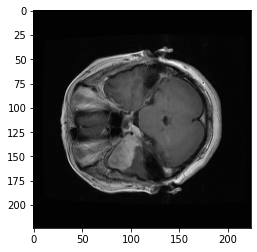

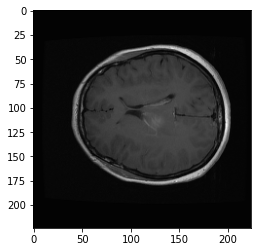

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


704

In [11]:
  def upd(dk,data):
    if dk==0:
        dk=data
    else:
        for ky in data.keys():
            dk[ky].extend(data[ky])
    return dk
  index=4
  epoch=50
  pre_acc=0
  best=0
  fold='fold_'+str(index)
  trn,tst=get_trn_tst(df,index)
  history_last[fold]=0



  plt.imshow(trn[0][0])
  plt.show()
  plt.imshow(tst[0][0])
  plt.show()



  trn_x,trn_y=unison_shuffled_copies(trn[0],trn[1])
  tst_x,tst_y=unison_shuffled_copies(tst[0],tst[1])



  model=load_model()


  
  #compiling the model
  model.compile(optimizer=Adam(2e-4,decay=1e-6), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])
  train_data = DataGenerator(trn_x,pd.get_dummies(trn_y), batch_size=4, augment=True)
  ln=len(trn_y)
  # del([trn_x,trn_y,trn,tst])
  # gc.collect()
  #fitting the model
  #timing
  start=time.time()
  hist=model.fit_generator(train_data,epochs=50,steps_per_epoch=ln//4,verbose=0)
  history_last[fold]=upd(history_last[fold],hist.history)

  end=time.time()
  times_last[fold]=end-start

  #getting the prediction 
  pre=model.predict(tst_x)
  



  #select the maximum position
  pre=np.argmax(pre,1)
  predictions_last[fold]=pre

  
  
  
  #getting the accuracy
  new_acc=accuracy_score(pre,tst_y)

  


  #storing the predictions
  final_accuracy_last[fold]=new_acc








  #storing the answers
  answers_last[fold]=tst_y
    
    
    
    
  #freeing memory
  del([tst_x,tst_y])
  gc.collect()



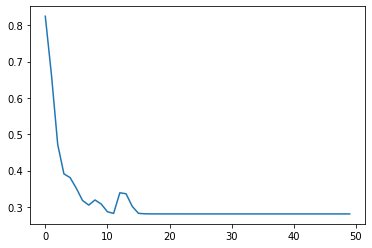

In [12]:
plt.plot(history_last[fold]['loss'])

In [13]:
new_acc

0.9554140127388535

In [14]:
index=str(index)
type='final_2416'
model1='final'
path='/content/gdrive/My Drive/'
np.save(path+"/best_accuracy_all_fold_"+index+"_"+model1+"_"+type+".npy",best_accuracy_last)
np.save(path+'/final_accuracy_all_fold'+index+"_"+model1+"_"+type+".npy",final_accuracy_last)
np.save(path+'/history_all_fold_'+index+"_"+model1+"_"+type+".npy",history_last)
np.save(path+'/answers_all_fold_'+index+"_"+model1+"_"+type+".npy",answers_last)
np.save(path+'/predictions_all_fold_'+index+"_"+model1+"_"+type+".npy",predictions_last)
np.save(path+'/predictions_all_best_fold_'+index+"_"+model1+"_"+type+".npy",predictions_last_best)
np.save(path+'/times_all_fold_'+index+"_"+model1+"_"+type+".npy",times_last)